In [1]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 5.7 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=1a31dc3eddfa58104b2c4ac63856dff028c6134645f9bedea10e773965e2a031
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [2]:
!pip install torch fastai music21 pebble midi2audio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 24 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5,420 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [

In [4]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import librosa
import pretty_midi
import torch
import matplotlib.pyplot as plt
import fluidsynth
from midi2audio import FluidSynth
import os
import glob
import pathlib
import pandas as pd
import collections
import urllib.request
import zipfile
import torch.utils.data as data
from torchvision import transforms
import tensorflow as tf
from IPython import display
import numpy as np
tf.random.set_seed(42)
np.random.seed(42)
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

In [6]:
## DownLoading the MAESTRO dataset
MAESTRO_DATASET_URL = "https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip"
MAESTRO_METADATA_URL = "https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0.json"
DATASET_DIR = './MAESTRO/'

if not os.path.exists(DATASET_DIR):
    os.mkdir(DATASET_DIR)

if not os.path.exists(DATASET_DIR + 'maestro-v3.0.0-midi.zip'):
    urllib.request.urlretrieve(MAESTRO_DATASET_URL, DATASET_DIR + 'maestro-v3.0.0-midi.zip')

with zipfile.ZipFile(DATASET_DIR + 'maestro-v3.0.0-midi.zip', 'r') as zip_ref:
    zip_ref.extractall(DATASET_DIR)

In [7]:
def plot_pitch(info_md, htee, bg_pitch = 20, dth_pitch = 108, fs = 20):
        
        piano_roll = info_md.get_piano_roll(fs) 
        
        fig = plt.figure(figsize = (10,8))
        
        # Display piano roll
        librosa.display.specshow(piano_roll[bg_pitch:dth_pitch],
                                hop_length = 1, sr = fs, x_axis = 'time', y_axis = 'cqt_note',
                                fmin = pretty_midi.note_number_to_hz(bg_pitch))
        plt.title(f'{htee}', fontsize = 'x-large')
        plt.xlabel('Time (s)', fontsize = 'x-large')
        plt.ylabel('Pitch', fontsize = 'x-large')
        
        plt.show()

<ipython-input-7-83055a6e465a>:8: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll[bg_pitch:dth_pitch],


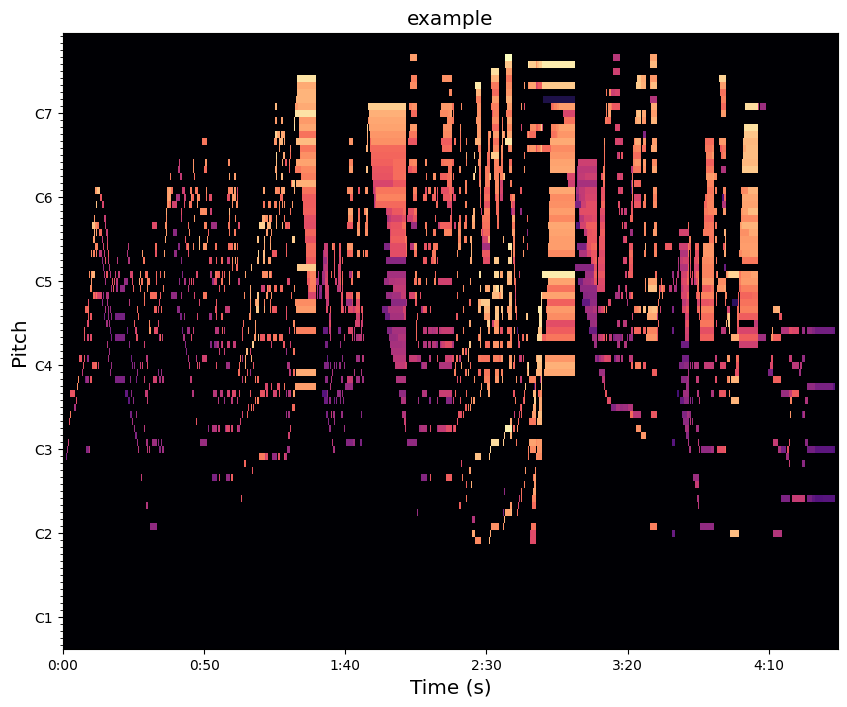

In [8]:
script_dir = os.path.dirname(os.getcwd())

# path to the MAESTRO folder
script_dir1 = os.path.join(script_dir, os.path.basename(os.getcwd()))
maestro_dir = os.path.join(script_dir1, 'MAESTRO/maestro-v3.0.0/')

midi_files = glob.glob(os.path.join(maestro_dir,'**/*.mid*'))

a_sample = pretty_midi.PrettyMIDI(midi_files[10])
plot_pitch(a_sample,'example')

In [9]:
def translator(midi_file: str) -> pd.DataFrame:
  info_md = pretty_midi.PrettyMIDI(midi_file)
  instrument = info_md.instruments[0]
  mscores = collections.defaultdict(list)

  s_msc = sorted(instrument.notes, key=lambda msc: msc.start)
  pb = s_msc[0].start

  for msc in s_msc:
    bg = msc.start
    dth = msc.end
    mscores['pitch'].append(msc.pitch)
    mscores['start'].append(bg)
    mscores['end'].append(dth)
    mscores['step'].append(bg - pb)
    mscores['duration'].append(dth - bg)
    pb = bg

  return pd.DataFrame({name: np.array(value) for name, value in mscores.items()})

In [10]:
import tensorflow as tf
def converter(
  mscores: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 90,
) -> pretty_midi.PrettyMIDI:

  info_md = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  pb = 0
  for i, msc in mscores.iterrows():
    bg = float(pb + msc['step'])
    dth = float(start + msc['duration'])
    msc = pretty_midi.Note(
        velocity=velocity,
        pitch=int(msc['pitch']),
        start=bg,
        end=dth,
    )
    instrument.notes.append(msc)
    pb = bg

  info_md.instruments.append(instrument)
  info_md.write(out_file)
  return info_md

In [11]:
all_mscores = []
for f in midi_files[:5]:
  mscores = translator(f)
  all_mscores.append(mscores)

all_mscores = pd.concat(all_mscores)

In [12]:
n_mscores = len(all_mscores)
print('Number of mscores parsed:', n_mscores)

Number of mscores parsed: 21135


In [33]:
def serial(dataset: tf.data.Dataset, seq_length: int, vocab_size = 128,
) -> tf.data.Dataset:

  seq_length = seq_length+1

  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  dv_foil = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(dv_foil)

  def tf_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  def classify(sequences):
    jins = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(attrs)}

    return tf_pitch(jins), labels

  return sequences.map(classify, num_parallel_calls=tf.data.AUTOTUNE)

In [34]:
attrs = ['pitch', 'step', 'duration']
train_mscores = np.stack([all_mscores[at] for at in attrs], axis=1)
mscores_ds = tf.data.Dataset.from_tensor_slices(train_mscores)

In [35]:
cascade = serial(mscores_ds, 25, 128)

In [36]:
n_mscores = len(all_mscores)
buffer_size = n_mscores - 25  # the number of items in the dataset
train_dtst = (cascade
            .shuffle(buffer_size)
            .batch(64, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [37]:
def pp_mean_square(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  pp = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + pp)

In [38]:
dim_in = (25, 3)
lr = 5e-3

jin = tf.keras.Input(dim_in)
x = tf.keras.layers.LSTM(128)(jin)

chu = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(jin, chu)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': pp_mean_square,
      'duration': pp_mean_square,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          67584       ['input_2[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_1[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_1[0][0]']                 
                                                                                            

In [39]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [40]:
model.evaluate(train_dtst, return_dict=True)

329/329 [==============================] - 4s 3ms/step - loss: 1.0694 - duration_loss: 0.7977 - pitch_loss: 4.8579 - step_loss: 0.0289


{'loss': 1.0694472789764404,
 'duration_loss': 0.7976992726325989,
 'pitch_loss': 4.857901096343994,
 'step_loss': 0.02885332703590393}

In [41]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [42]:
%%time
epochs = 60

history = model.fit(
    train_dtst,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/60
329/329 [==============================] - 4s 5ms/step - loss: 0.3144 - duration_loss: 0.0750 - pitch_loss: 4.1956 - step_loss: 0.0296
Epoch 2/60
329/329 [==============================] - 1s 5ms/step - loss: 0.2968 - duration_loss: 0.0674 - pitch_loss: 4.0298 - step_loss: 0.0279
Epoch 3/60
329/329 [==============================] - 1s 5ms/step - loss: 0.2935 - duration_loss: 0.0666 - pitch_loss: 3.9853 - step_loss: 0.0276
Epoch 4/60
329/329 [==============================] - 1s 5ms/step - loss: 0.2893 - duration_loss: 0.0663 - pitch_loss: 3.9047 - step_loss: 0.0278
Epoch 5/60
329/329 [==============================] - 1s 5ms/step - loss: 0.2873 - duration_loss: 0.0660 - pitch_loss: 3.8764 - step_loss: 0.0276
Epoch 6/60
329/329 [==============================] - 1s 5ms/step - loss: 0.2877 - duration_loss: 0.0657 - pitch_loss: 3.8850 - step_loss: 0.0278
Epoch 7/60
329/329 [==============================] - 1s 4ms/step - loss: 0.2845 - duration_loss: 0.0650 - pitch_loss: 3.848

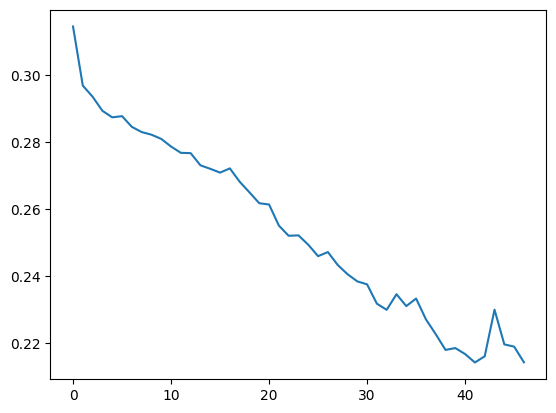

In [43]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [44]:
def creation_club(
    mscores: np.ndarray, 
    keras_model: tf.keras.Model, 
    tone: float = 1.0) -> int:

  assert tone > 0

  jins = tf.expand_dims(mscores, 0)

  compose = model.predict(jins)
  pitch_logits = compose['pitch']
  step = compose['step']
  duration = compose['duration']

  pitch_logits /= tone
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [45]:
sample_file = midi_files[1]
raw_mscores = translator(sample_file)

In [50]:
tone = 6.0
num_compose = 120

sample_mscores = np.stack([raw_mscores[key] for key in attrs], axis=1)

# The initial sequence of mscores; pitch is normalized similar to training
# sequences
jin_mscores = (
    sample_mscores[:25] / np.array([128, 1, 1]))

generated_mscores = []
prev_start = 0
for _ in range(num_compose):
  pitch, step, duration = creation_club(jin_mscores, model, tone)
  start = prev_start + step
  end = start + duration
  jin_msc = (pitch, step, duration)
  generated_mscores.append((*jin_msc, start, end))
  jin_mscores = np.delete(jin_mscores, 0, axis=0)
  jin_mscores = np.append(jin_mscores, np.expand_dims(jin_msc, 0), axis=0)
  prev_start = start

generated_mscores = pd.DataFrame(
    generated_mscores, columns=(*attrs, 'start', 'end'))

1/1 [==============================] - 0s 21ms/step


In [55]:
info_md = pretty_midi.PrettyMIDI(sample_file)
def display_audio(info_md: pretty_midi.PrettyMIDI, seconds=30):
  waveform = info_md.fluidsynth(fs=16000)
  waveform_short = waveform[:seconds*16000]
  return display.Audio(waveform_short, rate=16000)
instrument = info_md.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

In [56]:
out_file = 'chu.mid'
out_info_md = converter(
    generated_mscores, out_file=out_file, instrument_name=instrument_name)
display_audio(out_info_md)

<ipython-input-7-83055a6e465a>:8: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll[bg_pitch:dth_pitch],


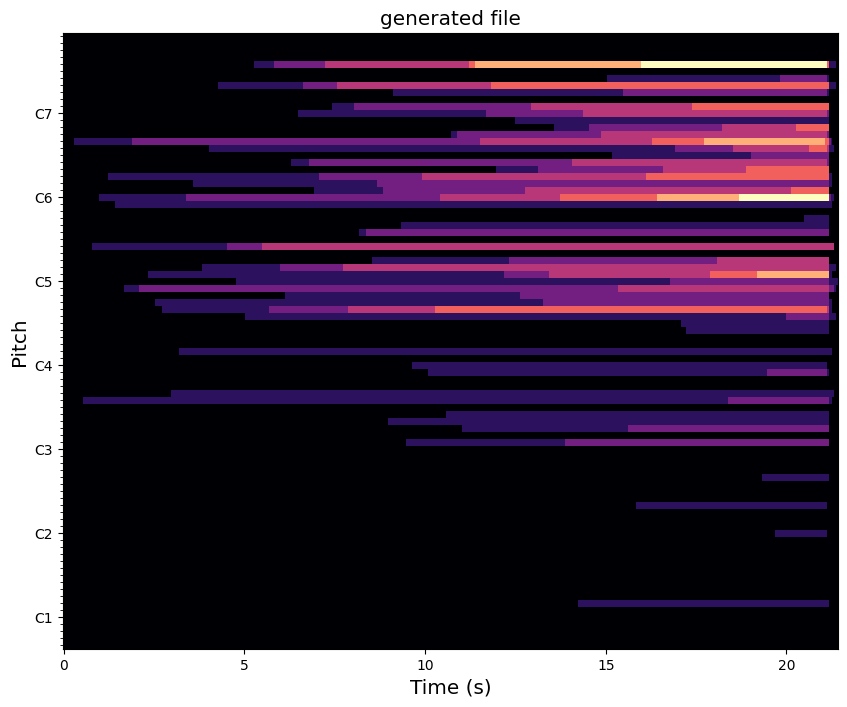

In [57]:
plot_pitch(out_info_md,'generated file')